In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
import emm
import warnings
warnings.filterwarnings('ignore')

# Plot styles
plt.style.use('seaborn-notebook')

import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [2]:
# Generate example data
m = 10000

# Target distribution
mu0 = np.array([-0.3]); sig0 = np.array([0.35])
mu1 = np.array([0.2]); sig1 = np.array([0.3])

import scipy as sp
rv0 = sp.stats.skewnorm(a=0, loc=mu0[0], scale=sig0[0])
rv1 = sp.stats.skewnorm(a=0, loc=mu1[0], scale=sig1[0])

X0 = rv0.rvs(size=m // 4)
X1 = rv1.rvs(size=m // 4)
y0 = np.zeros(m // 4)
y1 = np.ones(m // 4)
X = np.concatenate([X0,X1])
y = np.concatenate([y0,y1])


target = pd.DataFrame({'feature' : X})
target['Outcome'] = y

# Corpus distribution
mu = np.array([-1]); sig = np.array([2])
rvc = sp.stats.skewnorm(a=2,loc=mu,scale=sig)
corpus = rvc.rvs(size=m)
corpus = pd.DataFrame({'feature': corpus})

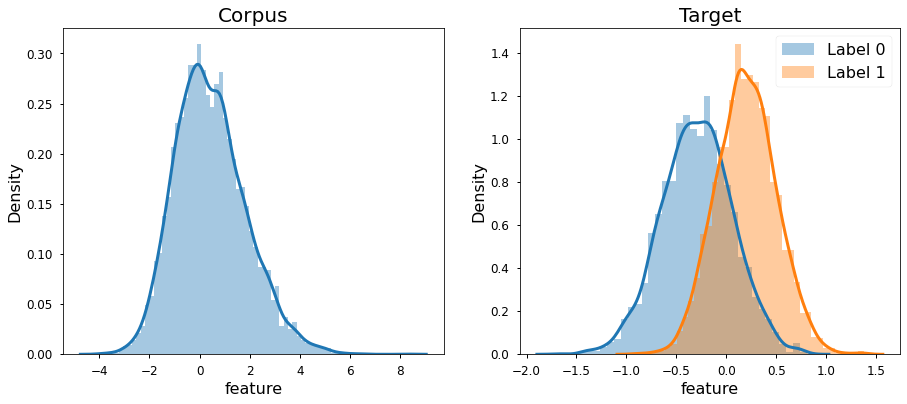

In [3]:
bins_target = np.histogram_bin_edges(target['feature'],bins='auto')
bins = np.histogram_bin_edges(corpus['feature'],bins='auto')


fig, axs = plt.subplots(1,2,figsize=(15,6), sharey=False)

sns.distplot(corpus['feature'], bins=bins,ax=axs[0], kde_kws=dict(linewidth=3))
sns.distplot(target[target['Outcome']==0]['feature'],ax=axs[1], kde_kws=dict(linewidth=3), label='Label 0')
sns.distplot(target[target['Outcome']==1]['feature'],ax=axs[1], kde_kws=dict(linewidth=3), label='Label 1')
axs[0].set_title('Corpus', fontsize=20)
axs[1].set_title('Target', fontsize=20)
plt.legend(fontsize=16)
plt.savefig('simple_cont_corp_targ.jpg')

plt.show()

In [276]:
from emm.reweighting import marginal
histLoss0 = emm.losses.CorpusKLLoss(mean=mu0[0], std=sig0[0],scale=2)
histLoss1 = emm.losses.CorpusKLLoss(mean=mu1[0], std=sig1[0], scale=2)



lam = 0
margsKL = {
            0 : [marginal('feature', histLoss0.fun, histLoss0)],
            1 : [marginal('feature', histLoss1.fun, histLoss1)]
          }
                              
margsLS = {
            0 : [marginal('feature', 'mean', emm.losses.LeastSquaresLoss(mu0[0], scale=100), False),
                 marginal('feature', 'var', emm.losses.LeastSquaresLoss(sig0[0]**2, scale=100), False)],
                                  
            1 : [marginal('feature', 'mean', emm.losses.LeastSquaresLoss(mu1[0], scale=100), False),
                marginal('feature', 'var', emm.losses.LeastSquaresLoss(sig1[0]**2, scale=100), False)]
           }

margsEQ = {
            0 : [marginal('feature', 'mean', emm.losses.EqualityLoss(mu0[0]), True)],
                 #marginal('feature', 'var', emm.losses.LeastSquaresLoss(sig0[0]**2), True)],
                                  
            1 : [marginal('feature', 'mean', emm.losses.EqualityLoss(mu1[0]), True)],
                #marginal('feature', 'var', emm.losses.LeastSquaresLoss(sig1[0]**2), True)]
           }

    

    
margs = [margsKL, margsLS]

from sklearn.linear_model import LogisticRegression
# param_grid_log =  {"classifier" : [LogisticRegression()],
#                  "classifier__C": np.logspace(-3,2,10), 
#                    "classifier__penalty":["l1","l2"]}
param_grid_log = {"classifier" : [LogisticRegression()]}
from sklearn.tree import DecisionTreeClassifier
# param_grid_tree =  {'classifier' : [DecisionTreeClassifier()],
#      'classifier__max_depth' : [2,4,5,6,7,9]}

param_grid_tree = {'classifier' : [DecisionTreeClassifier()]}
from sklearn.ensemble import RandomForestClassifier

# param_grid_rf = {'classifier' : [RandomForestClassifier()],
#     'classifier__bootstrap': [True],
#     'classifier__max_depth': [2,3,5,8],
#     'classifier__min_samples_leaf': [0,1,2,4],
#     'classifier__min_samples_split': [0,1,2,4],
#     'classifier__n_estimators': [1,2,3]
# }
param_grid_rf = {'classifier' : [RandomForestClassifier()]}
param_grid = [param_grid_log, param_grid_tree, param_grid_rf]


   
(rwcs1, js1, score1) =emm.metrics.multiple_models(target,corpus,margs, 
                                        param_grid, verbose=True, 
                                    regularizer=emm.regularizers.EntropyRegularizer(), lam=1e-8, test_size=0.05)
(rwcs2, js2, score2) =emm.metrics.multiple_models(target,corpus,margs, 
                                        param_grid, verbose=True, 
                                    regularizer=emm.regularizers.EntropyRegularizer(), lam=0.001, test_size=0.05)
(rwcs3, js3, score3) =emm.metrics.multiple_models(target,corpus,margs, 
                                        param_grid, verbose=True, 
                                    regularizer=emm.regularizers.EntropyRegularizer(), lam=100, test_size=0.05)

CVX took 3.21999 seconds
CVX took 2.65013 seconds
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Target data: the best parameters are given by 
 LogisticRegression()
 the best mean cross-validation accuracy 77.68421 +/- 1.28921% on training dataset 

Weighted data: the best parameters are given by 
 LogisticRegression()
 the best mean cross-validation accuracy 45.15403 +/- 12.16698% on training dataset 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Target data: the best parameters are given by 
 DecisionTreeClassifier()
 the best mean cross-validation accuracy 69.41053 +/- 1.15809% on training dataset 

Weighted data: the best parameters are given by 
 DecisionTreeClassifier()
 the best mean cross-validation accuracy 7.31937 +/- 0.97633% on training dataset 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 10 folds for ea

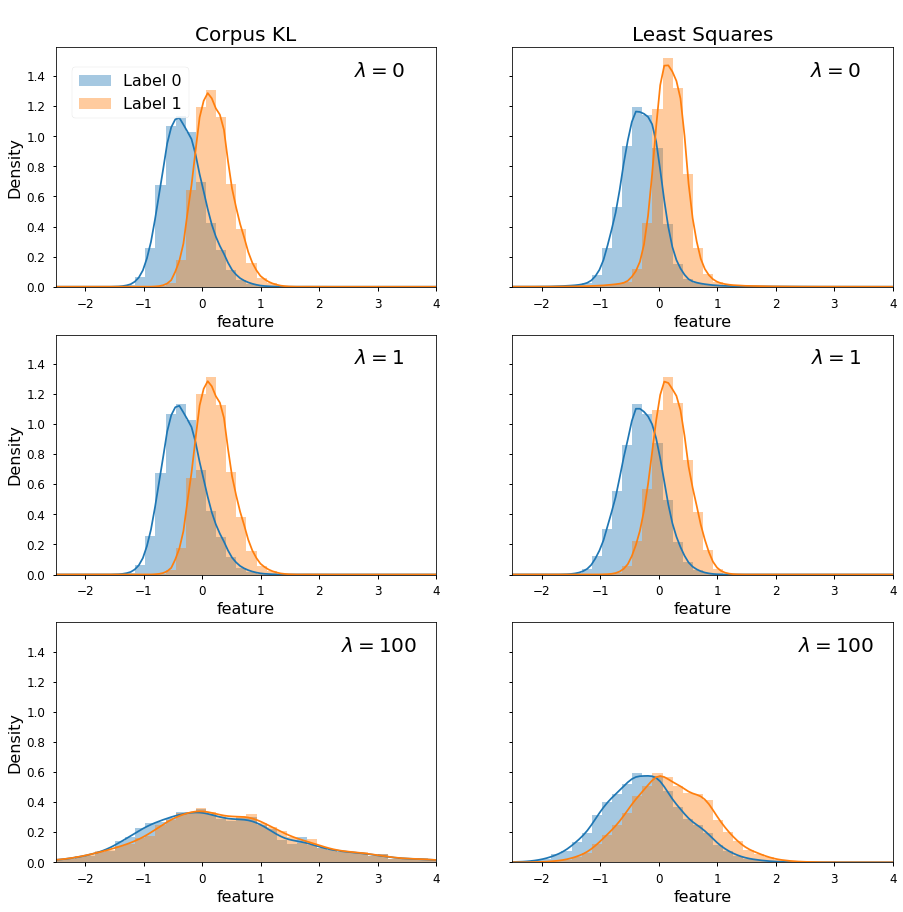

In [277]:
fig, axs = plt.subplots(3,2, figsize=(15,15), sharey=True)
emm.utils.weighted_hist(rwcs1[0]['feature'][:m], rwcs1[0]['weights'][:m], ax=axs[0,0],label='Label 0')
emm.utils.weighted_hist(rwcs1[0]['feature'][m:], rwcs1[0]['weights'][m:], ax=axs[0,0],label='Label 1')
emm.utils.weighted_hist(rwcs1[1]['feature'][:m], rwcs1[1]['weights'][:m], ax=axs[0,1])
emm.utils.weighted_hist(rwcs1[1]['feature'][m:], rwcs1[1]['weights'][m:], ax=axs[0,1])
emm.utils.weighted_hist(rwcs2[0]['feature'][:m], rwcs2[0]['weights'][:m], ax=axs[1,0])
emm.utils.weighted_hist(rwcs2[0]['feature'][m:], rwcs2[0]['weights'][m:], ax=axs[1,0])
emm.utils.weighted_hist(rwcs2[1]['feature'][:m], rwcs2[1]['weights'][:m], ax=axs[1,1])
emm.utils.weighted_hist(rwcs2[1]['feature'][m:], rwcs2[1]['weights'][m:], ax=axs[1,1])
emm.utils.weighted_hist(rwcs3[0]['feature'][:m], rwcs3[0]['weights'][:m], ax=axs[2,0])
emm.utils.weighted_hist(rwcs3[0]['feature'][m:], rwcs3[0]['weights'][m:], ax=axs[2,0])
emm.utils.weighted_hist(rwcs3[1]['feature'][:m], rwcs3[1]['weights'][:m], ax=axs[2,1])
emm.utils.weighted_hist(rwcs3[1]['feature'][m:], rwcs3[1]['weights'][m:], ax=axs[2,1])
axs[0,0].set_title('Corpus KL',fontsize=20)
axs[0,1].set_title('Least Squares', fontsize=20)
axs[2,0].text(0.85, 0.9, '$\lambda = 100$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[2,0].transAxes)
axs[2,1].text(0.85, 0.9, '$\lambda = 100$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[2,1].transAxes)
axs[1,0].text(0.85, 0.9, '$\lambda = 1$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[1,0].transAxes)
axs[1,1].text(0.85, 0.9, '$\lambda = 1$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[1,1].transAxes)
axs[0,0].text(0.85, 0.9, '$\lambda = 0$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[0,0].transAxes)
axs[0,1].text(0.85, 0.9, '$\lambda = 0$', fontsize=20, horizontalalignment='center', verticalalignment='center', transform=axs[0,1].transAxes)
fig.legend(loc = (0.08,0.87), fontsize=16)
plt.setp(axs, xlim=(-2.5,4))
plt.savefig('simple_cont_compare.jpg')
plt.show()

In [278]:
display(pd.DataFrame(js1))
display(pd.DataFrame(js2))
display(pd.DataFrame(js3))

,0.0,1.0
0,0.076298,0.145798
1,0.076213,0.171531


,0.0,1.0
0,0.076275,0.145791
1,0.053916,0.095187


,0.0,1.0
0,0.318013,0.698528
1,0.247234,0.565020


In [250]:
display(pd.concat([pd.DataFrame(l) for l in score1],axis=0))
display(pd.concat([pd.DataFrame(l) for l in score2],axis=0))
display(pd.concat([pd.DataFrame(l) for l in score3],axis=0))

,accuracy_score,RR,RS,SS,SR
0,LogisticRegression,0.820,0.756361,0.484215,0.496
0,DecisionTreeClassifier,0.728,0.644352,0.029411,0.508
0,RandomForestClassifier,0.812,0.777384,0.457954,0.540
0,LogisticRegression,0.772,0.803100,0.432462,0.504
0,DecisionTreeClassifier,0.704,0.696086,0.011370,0.500
0,RandomForestClassifier,0.768,0.810988,0.776200,0.804


,accuracy_score,RR,RS,SS,SR
0,LogisticRegression,0.792,0.775162,0.449101,0.480
0,DecisionTreeClassifier,0.704,0.690031,0.015249,0.552
0,RandomForestClassifier,0.748,0.759655,0.459401,0.500
0,LogisticRegression,0.756,0.769121,0.441050,0.484
0,DecisionTreeClassifier,0.712,0.691172,0.025405,0.472
0,RandomForestClassifier,0.800,0.775824,0.715951,0.760


,accuracy_score,RR,RS,SS,SR
0,LogisticRegression,0.816,0.520006,0.489038,0.540
0,DecisionTreeClassifier,0.728,0.530869,0.018132,0.484
0,RandomForestClassifier,0.776,0.513398,0.482839,0.472
0,LogisticRegression,0.740,0.636565,0.481423,0.436
0,DecisionTreeClassifier,0.676,0.629167,0.029587,0.504
0,RandomForestClassifier,0.784,0.619271,0.378957,0.280


In [271]:
from sklearn.model_selection import train_test_split
# reweighted data
X = rwcs2[1].drop(columns='Outcome')
y= rwcs2[1][['Outcome']]

X.to_csv('X_weighted.csv')
y.to_csv('y_weighted.csv')

target.to_csv('target.csv')

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [272]:
# Calculate accuracy percentage between two lists
def accuracy_metric(actual, predicted, w):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1 * w[i]
    return correct / sum(w)

In [273]:
from sklearn.metrics import accuracy_score
# Fit on reweighted data
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_train.iloc[:,[0]], y_train, X_train.iloc[:,1]).score(X_train.iloc[:,[0]], y_train, X_train.iloc[:,1])

0.7856039016673606

In [274]:
clf.score(X_test.iloc[:,[0]], y_test, X_test.iloc[:,1])

0.7566649741780319

In [275]:
# predict on target data (real data) to see if classifier works well on real data
clf.score(np.array(target['feature']).reshape(-1,1), np.array(target['Outcome']).reshape(-1,1), sample_weight=np.ones(m//2))

0.7756